In [92]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sn
import time 
import matplotlib.animation as ani
import matplotlib.dates as mdates
import datetime
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator
import pync

### load & first clean

In [93]:
dff = pd.read_excel('Data2.xlsx')
dff.replace(0, float('NaN'), inplace=True)
dff.dropna(inplace=True)

### Formula to add Stock/Bond Ratio to df

In [14]:
def Add_SBRatioRank(df, n):
# calculate and add Stock/Bond Ratio Rank
# first calculate all in a seperate 
    
    df['Stock_r'] = np.log(df['Stock_P']/df['Stock_P'].shift(20))
    df['Bond_r'] = np.log(df['Bond_P']/df['Bond_P'].shift(20))
    
    df['SB_Dif'] = df['Stock_r']-df['Bond_r']
    df['SB_Ratio'] = df['Stock_P']/df['Bond_P']
    df['SB_Ratio_Rank'] = (df['SB_Ratio']-df['SB_Ratio'].rolling(n).min())/(df['SB_Ratio'].rolling(n).max()-df['SB_Ratio'].rolling(n).min())
    
    return df

### Formula to add RiskPremium to df

In [15]:
def Add_RiskPremiumRank(df, n):
# calculate risk premium Rank

    df['Risk_Premium'] = (df['US10Y_Yield'])/(100*df['Earnings']/df['SPX_P'])
    df['Risk_Premium_Rank'] = (df['Risk_Premium']-df['Risk_Premium'].rolling(n).min())/(df['Risk_Premium'].rolling(n).max()-df['Risk_Premium'].rolling(n).min())
    
    return df

### Formula to Add Put/Call Impl Vol to df

In [16]:
def Add_PutCallVolRank(df, n):
# calculate Put/Call Implied Volatility Rank

    df['SPX_Impl_Spread_P-C_Rank'] = -1*(df['SPX_Impl_Spread_P-C']-df['SPX_Impl_Spread_P-C'].rolling(n).min())/(df['SPX_Impl_Spread_P-C'].rolling(n).max()-df['SPX_Impl_Spread_P-C'].rolling(n).min())+1
    
    return df


### Formula to add Vola Curve Slope Z Score to df

In [17]:
def Add_Vola_CurveRank(df,n):
# calculate Vola Curve Rank
    
    df['Vola_Slope_Rank'] = (df['Vola_Slope']-df['Vola_Slope'].rolling(n).min())/(df['Vola_Slope'].rolling(n).max()-df['Vola_Slope'].rolling(n).min())
    
    return df

In [18]:
def Add_SEKJPYRank(df, n):
    
    df['SEKJPY_Rank'] = (df['SEKJPY']-df['SEKJPY'].rolling(n).min())/(df['SEKJPY'].rolling(n).max()-df['SEKJPY'].rolling(n).min())
    
    
    return df

In [87]:
def Add_HLRank(df, n):
    
    df['High_Low'] = df['NY_HIGH']/df['NY_LOW']
    df['Low_Rank'] = -1*(np.log(df['NY_LOW'])-np.log(df['NY_LOW']).rolling(n).min())/(np.log(df['NY_LOW']).rolling(n).max()-np.log(df['NY_LOW']).rolling(n).min())+1
    df['High_Rank'] = (df['NY_HIGH']-df['NY_HIGH'].rolling(n).min())/(df['NY_HIGH'].rolling(n).max()-df['NY_HIGH'].rolling(n).min())
    df['High-Low'] = df['NY_HIGH']-df['NY_LOW']
    df['High_Low_Rank_0'] = (df['High-Low']-df['High-Low'].rolling(n-40).min())/(df['High-Low'].rolling(n-40).max()-df['High-Low'].rolling(n-40).min())
    df['High_Low_Rank_1'] = (df['High-Low']-df['High-Low'].rolling(n).min())/(df['High-Low'].rolling(n).max()-df['High-Low'].rolling(n).min())
    df['High_Low_Rank_2'] = (df['High-Low']-df['High-Low'].rolling(n+40).min())/(df['High-Low'].rolling(n+40).max()-df['High-Low'].rolling(n+40).min())
    df['High_Low_Rank'] = (df['High_Low_Rank_0'] +df['High_Low_Rank_1'] +df['High_Low_Rank_2'])/3
    
    
    return df

In [88]:
def MA(serIn, n):
    
    if n == 0:
        serOut = serIn
    else:
        serOut = serIn.rolling(n).mean()
    return serOut

In [89]:
def Rank(SerIn, n):
    
    SerOut = (SerIn-SerIn.rolling(n).min())/(SerIn.rolling(n).max()-SerIn.rolling(n).min())
    return SerOut

In [90]:
def do_Strat(dff, n1=150, n2=170, n3=190, n4=310, n5=60, n6=270, n7=200, a1=10, a2=10, a3=10, a4=10, a5=10, a6=10, a7=20, a=40, evaluate=True):
    
# do the strategy and chose 

# copy the dataframe to use 
    df = dff.copy()

# calculate future Returns
    df['1M nReturn'] = np.log(df['Stock_P'].shift(-21)/df['Stock_P'].shift(-1))
    df['3M nReturn'] = np.log(df['Stock_P'].shift(-61)/df['Stock_P'].shift(-1))
    df['6M nReturn'] = np.log(df['Stock_P'].shift(-121)/df['Stock_P'].shift(-1))
    df['Stock_MA'] = df.Stock_P.rolling(a).mean()

# calculate values 
    df = Add_SBRatioRank(df, n1)
    df = Add_RiskPremiumRank(df, n2)
    df = Add_PutCallVolRank(df, n3)
#     df = Add_HYCDSRank(df, 100)
    df = Add_Vola_CurveRank(df, n4)
#     df = Add_DollarRank(df, 100)
    df = Add_SEKJPYRank(df, n5)
    df = Add_HLRank(df, n6)
    
    
    df['SB_Ratio_Rank'] = MA(df['SB_Ratio_Rank'],a1)
    df['Risk_Premium_Rank'] = MA(df['Risk_Premium_Rank'], a2)
    df['Vola_Slope_Rank'] = MA(df['Vola_Slope_Rank'], a3) 
#     df['HY_CDS_Rank'] = MA(df['HY_CDS_Rank'], a4)
    df['SPX_Impl_Spread_P-C_Rank'] = MA(df['SPX_Impl_Spread_P-C_Rank'],a4)
    df['SEKJPY_Rank'] = MA(df['SEKJPY_Rank'], a5)
#     df['Dollar_Rank'] = MA(df['Dollar_Rank'], a6)
    df['High_Low_Rank'] = MA(df['High_Low_Rank'], a6)

# create Score
    df['Score'] = df['SB_Ratio_Rank']+df['Risk_Premium_Rank']+df['Vola_Slope_Rank']+df['SPX_Impl_Spread_P-C_Rank']+df['High_Low_Rank']+df['SEKJPY_Rank']
#     *1.2+df['HY_CDS_Rank'] +df['Dollar_Rank']
    df['Score_MA'] = df['Score'].rolling(n7).mean()
    df['Score_Z'] = (df['Score']-df['Score_MA'])/df['Score'].rolling(n7).std()
    df['Score_Rank'] = (df['Score']-df['Score'].rolling(n7).min())/(df['Score'].rolling(n7).max()-df['Score'].rolling(n7).min())
    df['Score_Rank'] = MA(df['Score_Rank'],a7)**2

# drop NaN    
    if evaluate:
        df.dropna(inplace=True)

    return df

In [58]:
aaa = 0 
bbb = 1
ccc = 0
ddd = 10 
eee = 5


a1 = 20
b1 = 150 # SB Ratio 
c1 = 170 #Risk Prem
d1 = 190 #PC Vol
e1 = 300 #Vol Slop
f1 = 60 #SEKJ
g1 = 270 #HL 
h1 = 200

while (aaa <= 10) or (ccc>=20):
    ccc+=1
    print(f'ROUND {bbb}')
    print(f'SCORE {aaa}')
    result = pd.DataFrame(columns=['a7',
                                   'n1', 
                                   'n2',
                                   'n3',
                                   'n4',
                                   'n5',
                                   'n6',
                                   'n7',
                                   '# S',
                                   '6MS',
                                   '3MS',
                                   '# B',
                                   '6MSH', 
                                   '3MSH',
                                   'Last Sell' 
                                  ])

    s = 0

    for a in tqdm(np.linspace(a1-5, a1+5, 3), leave=True):
        for b in tqdm(np.linspace(b1-ddd, b1+ddd, 3)):
            for c in np.linspace(c1-ddd, c1+ddd, 3):
                for d in np.linspace(d1-ddd, d1+ddd, 3):
                    for e in np.linspace(e1-ddd, e1+ddd, 3):
                        for f in np.linspace(f1-ddd, f1+ddd, 3):
                            for g in np.linspace(g1-ddd, g1+ddd, 3):
                                for h in np.linspace(h1-ddd, h1+ddd, 3):
                                    
                                    df = do_Strat(dff, a7=int(a), n1=int(b), n2=int(c), n3=int(d), n4=int(e), n5=int(f), n6=int(g), n7=int(h))

                                    df['SELL'] = (df['Score_Rank'] > 0.8) & (df['Score_Rank'].shift(1) > df['Score_Rank']) & (df['Score_Rank'].shift(2) < df['Score_Rank'].shift(1))
                                    df['BUY'] = (df['Score_Rank'] < (0.2)) & (df['Score_Rank'].shift(1) < df['Score_Rank']) & (df['Score_Rank'].shift(2) > df['Score_Rank'].shift(1))

                                    dfff = do_Strat(dff, a7=int(a), n1=int(b), n2=int(c), n3=int(d), n4=int(e), n5=int(f), n6=int(g), n7=int(h), evaluate=False)


                                    dfff['SELL'] = (dfff['Score_Rank'] < 0.8) & (dfff['Score_Rank'].shift(1) > 0.8) 

                                    p = ((dfff['SELL'][100:600].sum()>0).astype(int))+((dfff['SELL'][900:1200].sum()>0).astype(int))+((dfff['SELL'][1900:2150].sum()>0).astype(int))+((dfff['SELL'][2500:3100].sum()>0).astype(int))+((dfff['SELL'][3300:3500].sum()>0).astype(int))

                                    i = df['SELL'].sum()
                                    j = ((df['6M nReturn']*df['SELL']*-1).sum())/(df['SELL'].sum())
                                    k = ((df['3M nReturn']*df['SELL']*-1).sum())/(df['SELL'].sum())

                                    l = df['BUY'].sum()
                                    m = round(len([num for num in (df['6M nReturn']*df['SELL']) if num < 0])/len([num for num in (df['6M nReturn']*df['SELL']) if num != 0]),2)
    #                                 ((df['6M nReturn']*df['BUY']*1).sum())/(df['BUY'].sum())
                                    n = round(len([num for num in (df['3M nReturn']*df['SELL']) if num < 0])/len([num for num in (df['3M nReturn']*df['SELL']) if num != 0]),2)
    #     ((df['3M nReturn']*df['BUY']*1).sum())/(df['BUY'].sum())
                                    o = round(len([num for num in (df['6M nReturn']*df['BUY']) if num > 0])/len([num for num in (df['6M nReturn']*df['BUY']) if num != 0]),2) + round(len([num for num in (df['3M nReturn']*df['BUY']) if num > 0])/len([num for num in (df['6M nReturn']*df['BUY']) if num != 0]),2)

                                    result = result.append(pd.Series([0]), ignore_index=True)

                                    result.iloc[s, 0] = a
                                    result.iloc[s, 1] = b
                                    result.iloc[s, 2] = c
                                    result.iloc[s, 3] = d
                                    result.iloc[s, 4] = e
                                    result.iloc[s, 5] = f
                                    result.iloc[s, 6] = g
                                    result.iloc[s, 7] = h
                                    result.iloc[s, 8] = i
                                    result.iloc[s, 9] = j
                                    result.iloc[s, 10] = k
                                    result.iloc[s, 11] = l
                                    result.iloc[s, 12] = m
                                    result.iloc[s, 13] = n
                                    result.iloc[s, 14] = o
                                    result.iloc[s, 15] = p

                                    

                                    s+=1
    result['Score'] = ((result['6MSH']+result['3MSH'])+ result['Last Sell'])
#                        (result[0]))*((result['6MS']>0).astype(int))
#     (((result['Last Sell'] >0).astype(int))*((result[0]<3).astype(int))*(result["6MS"]*10*(result['# S']/2)))-((result["6MSH"]==0).astype(int))
    aaa = result['Score'].max()
    bbb+=1
    a = result[(result['Score'] == result['Score'].max())]
    print(a)
    
    result.sort_values(by=['Score'], ascending=False, inplace=True)

#     a1 = max([result.iloc[1,0],15])
#     b1 = max([result.iloc[1,1],40])
#     c1 = max([result.iloc[1,2],40])
#     d1 = max([result.iloc[1,3],40])
#     e1 = max([result.iloc[1,4],40])
#     f1 = max([result.iloc[1,5],40])
#     g1 = max([result.iloc[1,6],40])
#     h1 = max([result.iloc[1,7],40])
    a1 = max([round(sum(result.iloc[1:eee,0].to_list())/len(result.iloc[1:eee,0].to_list()),-1),15])
    b1 = max([round(sum(result.iloc[1:eee,1].to_list())/len(result.iloc[1:eee,1].to_list()),-1),60])
    c1 = max([round(sum(result.iloc[1:eee,2].to_list())/len(result.iloc[1:eee,2].to_list()),-1),60])
    d1 = max([round(sum(result.iloc[1:eee,3].to_list())/len(result.iloc[1:eee,3].to_list()),-1),60])
    e1 = max([round(sum(result.iloc[1:eee,4].to_list())/len(result.iloc[1:eee,4].to_list()),-1),60])
    f1 = max([round(sum(result.iloc[1:eee,5].to_list())/len(result.iloc[1:eee,5].to_list()),-1),60])
    g1 = max([round(sum(result.iloc[1:eee,6].to_list())/len(result.iloc[1:eee,6].to_list()),-1),60])
    h1 = max([round(sum(result.iloc[1:eee,7].to_list())/len(result.iloc[1:eee,7].to_list()),-1),60])

pync.notify("Its done with {aaa}")

  0%|          | 0/3 [00:00<?, ?it/s]

ROUND 1
SCORE 0


  0%|          | 0/3 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [27]:


sum(result.iloc[1:5,0].to_list())/len(result.iloc[1:5,0].to_list())

10.0

          6-Month Return

6M Sell Return is 6.1% on average from 15 signals
Hit-rate: 0.73

6M Buy Return is 7.9% on average from 42 signals
Hit-rate: 0.81

The Average 6M Return is 3.5%



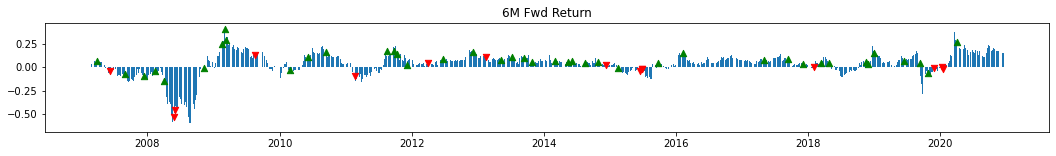

          --------------------

          3-Month Return

3M Sell Return is 4.4% on average from 15 signals
Hit-rate: 0.73

3M Buy Return is 4.9% on average from 42 signals
Hit-rate: 0.88


The Average 3M Return is 1.7%



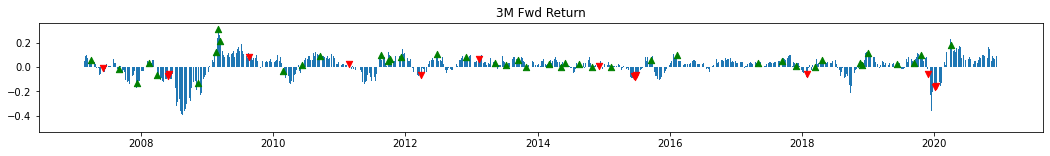

          --------------------

          3-Month Return

1M Sell Return is 0.2% on average from 15 signals
Hit-rate: 0.53

3M Buy Return is 2.2% on average from 42 signals
Hit-rate: 0.76


The Average 3M Return is 0.6%



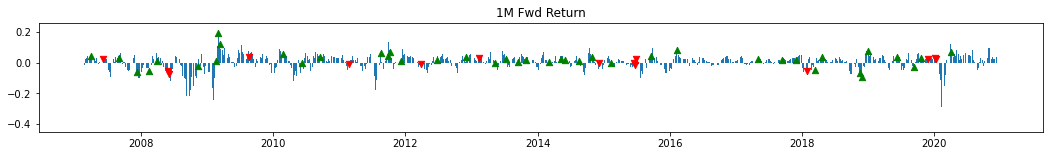

          --------------------



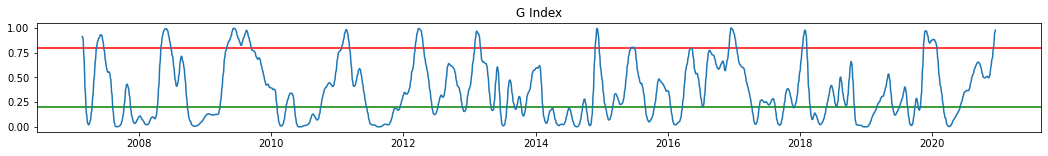

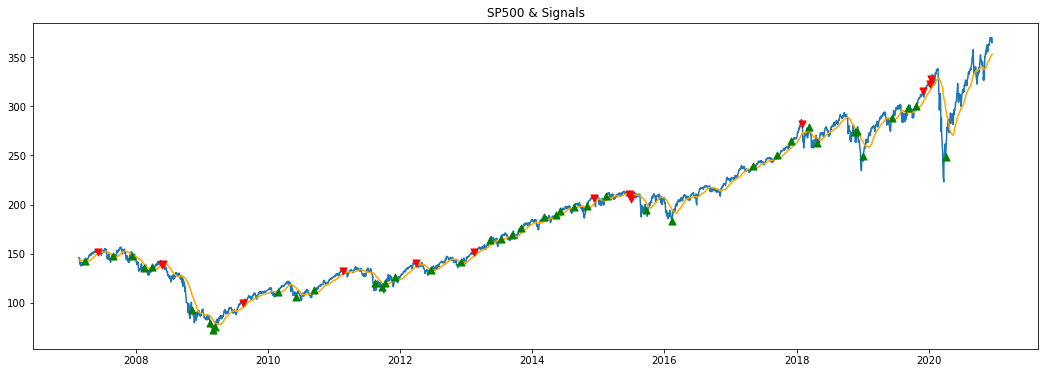

In [85]:
buy = 0.2
sell = 0.8

%matplotlib inline 

df = do_Strat(dff)

df['SELL'] = (df['Score_Rank'] > 0.8) & (df['Score_Rank'].shift(1) > df['Score_Rank']) & (df['Score_Rank'].shift(2) < df['Score_Rank'].shift(1)) 
df['BUY'] = (df['Score_Rank'] < (0.2)) & (df['Score_Rank'].shift(1) < df['Score_Rank']) & (df['Score_Rank'].shift(2) > df['Score_Rank'].shift(1)) 


print("          6-Month Return")
print('')
print(f"6M Sell Return is {round(((df['6M nReturn']*df['SELL']*-1).sum()/df['SELL'].sum())*100,1)}% on average from {df['SELL'].sum()} signals")
print(f"Hit-rate: {round(len([num for num in (df['6M nReturn']*df['SELL']) if num < 0])/len([num for num in (df['6M nReturn']*df['SELL']) if num != 0]),2)}")
print('')
print(f"6M Buy Return is {round(((df['6M nReturn']*df['BUY']).sum()/df['BUY'].sum())*100,1)}% on average from {df['BUY'].sum()} signals")
print(f"Hit-rate: {round(len([num for num in (df['6M nReturn']*df['BUY']) if num > 0])/len([num for num in (df['6M nReturn']*df['BUY']) if num != 0]),2)}")
print('')
print(f"The Average 6M Return is {round(df['6M nReturn'].sum()/df['6M nReturn'].count()*100, 1)}%")
print('')
plt.figure(figsize=(18, 2))
plt.bar(df['Date'], df['6M nReturn'], width=1, zorder=0)
plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], '6M nReturn'].values, label='skitscat', color='red', s=40, marker="v", zorder=10)
plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], '6M nReturn'].values, label='skitscat', color='green', s=40, marker="^", zorder=10)
plt.title('6M Fwd Return')
plt.show()
print('          --------------------')
print('')
print("          3-Month Return")
print('')
print(f"3M Sell Return is {round(((df['3M nReturn']*df['SELL']*-1).sum()/df['SELL'].sum())*100,1)}% on average from {df['SELL'].sum()} signals")
print(f"Hit-rate: {round(len([num for num in (df['3M nReturn']*df['SELL']) if num < 0])/len([num for num in (df['3M nReturn']*df['SELL']) if num != 0]),2)}")
print('')
print(f"3M Buy Return is {round(((df['3M nReturn']*df['BUY']).sum()/df['BUY'].sum())*100,1)}% on average from {df['BUY'].sum()} signals")
print(f"Hit-rate: {round(len([num for num in (df['3M nReturn']*df['BUY']) if num > 0])/len([num for num in (df['3M nReturn']*df['BUY']) if num != 0]),2)}")
print('')
print('')
print(f"The Average 3M Return is {round(df['3M nReturn'].sum()/df['3M nReturn'].count()*100, 1)}%")
print('')
plt.figure(figsize=(18, 2))
plt.bar(df['Date'], df['3M nReturn'], width=1, zorder=0)
plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], '3M nReturn'].values, label='skitscat', color='red', s=40, marker="v", zorder=10)
plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], '3M nReturn'].values, label='skitscat', color='green', s=40, marker="^", zorder=10)
plt.title('3M Fwd Return')
plt.show()
print('          --------------------')
print('')

print("          3-Month Return")
print('')
print(f"1M Sell Return is {round(((df['1M nReturn']*df['SELL']*-1).sum()/df['SELL'].sum())*100,1)}% on average from {df['SELL'].sum()} signals")
print(f"Hit-rate: {round(len([num for num in (df['1M nReturn']*df['SELL']) if num < 0])/len([num for num in (df['1M nReturn']*df['SELL']) if num != 0]),2)}")
print('')
print(f"3M Buy Return is {round(((df['1M nReturn']*df['BUY']).sum()/df['BUY'].sum())*100,1)}% on average from {df['BUY'].sum()} signals")
print(f"Hit-rate: {round(len([num for num in (df['1M nReturn']*df['BUY']) if num > 0])/len([num for num in (df['1M nReturn']*df['BUY']) if num != 0]),2)}")
print('')
print('')
print(f"The Average 3M Return is {round(df['1M nReturn'].sum()/df['1M nReturn'].count()*100, 1)}%")
print('')
plt.figure(figsize=(18, 2))
plt.bar(df['Date'], df['1M nReturn'], width=1, zorder=0)
plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], '1M nReturn'].values, label='skitscat', color='red', s=40, marker="v", zorder=10)
plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], '1M nReturn'].values, label='skitscat', color='green', s=40, marker="^", zorder=10)
plt.title('1M Fwd Return')
plt.show()
print('          --------------------')
print('')


plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['Score_Rank'], zorder=10)
plt.axhline(y=buy, color='g', linestyle='-', zorder=0)
plt.axhline(y=sell, color='r', linestyle='-', zorder=0)
plt.title('G Index')
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(df['Date'], df['Stock_P'], zorder=0)
plt.plot(df['Date'], df['Stock_MA'], color='orange', zorder=0)
plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], 'Stock_P'].values, label='skitscat', color='red', s=50, marker="v", zorder=10)
plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], 'Stock_P'].values, label='skitscat', color='green', s=50, marker="^", zorder=10)
plt.title('SP500 & Signals')
plt.show()

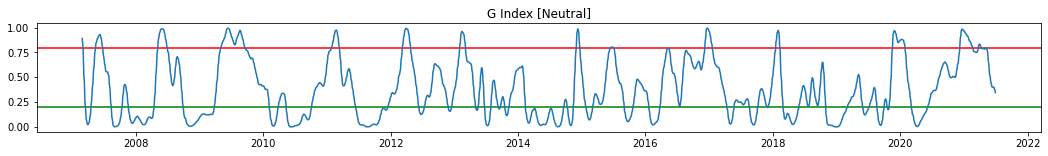

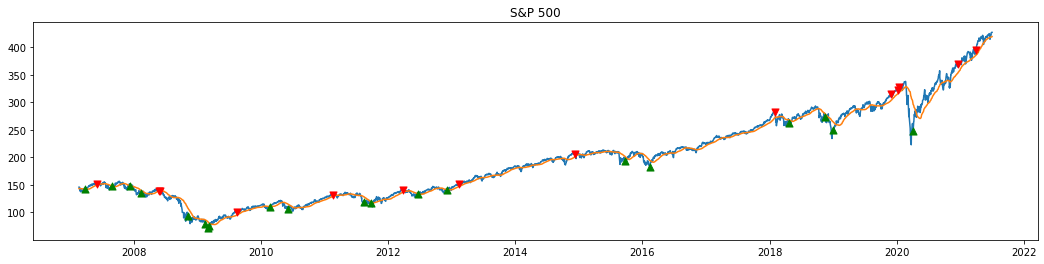

In [36]:

df = do_Strat(dff, evaluate=False)

sentiment = {0.0:'Starke Angst', 0.2:'Angst', 0.4:'Neutral', 0.6:'Euphorie', 0.8:'Starke Euphorie'}

buy=0.2
sell=0.8

df['SELL'] = (df['Score_Rank']> sell) & (df['Score_Rank'].shift(1) > df['Score_Rank']) & (df['Score_Rank'].shift(2) < df['Score_Rank'].shift(1))& (df['Stock_P']>df['Stock_MA'])
df['BUY'] = (df['Score_Rank'] < buy) & (df['Score_Rank'].shift(1) < df['Score_Rank']) & (df['Score_Rank'].shift(2) > df['Score_Rank'].shift(1)) &(df['Stock_P']<df['Stock_MA'])

df.dropna(subset=['Score_Rank'], inplace=True)

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], MA(df['Score_Rank'],5), zorder=10)
plt.axhline(y=buy, color='g', linestyle='-', zorder=0)
plt.axhline(y=sell, color='r', linestyle='-', zorder=0)
plt.title(f"G Index [{sentiment[round(df['Score_Rank'].iloc[-1]*5)/5]}]")
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(df['Date'], df['Stock_P'])
plt.plot(df['Date'], df['Stock_MA'])
plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], 'Stock_P'].values, label='skitscat', color='red', s=50, marker="v", zorder=10)
plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], 'Stock_P'].values, label='skitscat', color='green', s=50, marker="^", zorder=10)
plt.title('S&P 500')
plt.show()

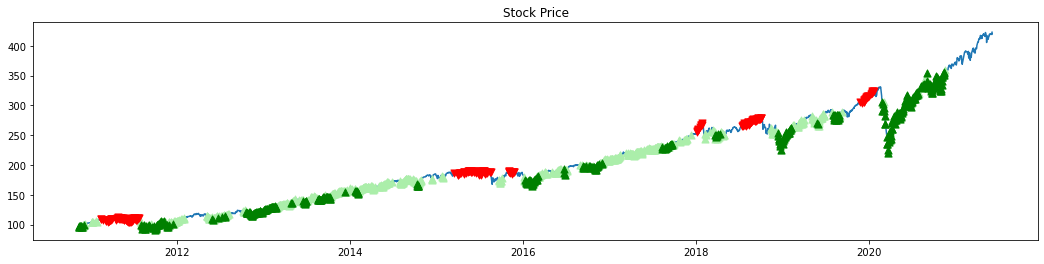

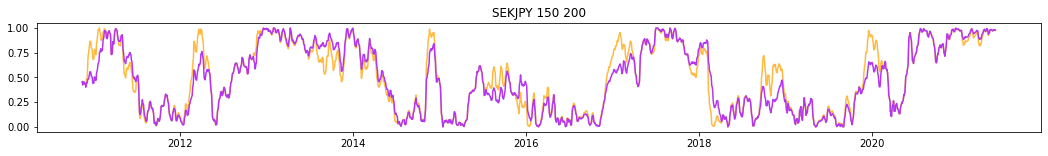

In [324]:
choose = 5

df = do_Strat(dff, evaluate=False)

options = ['SB_Dif', 'SB_Ratio', 'Risk_Premium', 'SPX_Impl_Spread_P-C', 'Vola_Slope', 'SEKJPY', 'High-Low' ]

rank = 150

df['SELL'] = (df['6M nReturn'] < 0) & (df['3M nReturn'] < 0)
df['BUY'] = (df['6M nReturn'] > 0.1) & (df['3M nReturn'] > 0.05)
df['BUY1'] = (df['6M nReturn'] > 0.05) & (df['3M nReturn'] > 0.02)

df[options[choose]+'1'] = MA(Rank(df[options[choose]], rank), 5)
df[options[choose]+'2'] = MA(Rank(df[options[choose]], rank+50), 5)
df.dropna(subset=[options[choose]+'2'], inplace=True)

plt.figure(figsize=(18, 4))
plt.plot(df['Date'], df['Stock_P'])
plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], 'Stock_P'].values, label='skitscat', color='red', s=50, marker="v", zorder=10)
plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], 'Stock_P'].values, label='skitscat', color='green', s=50, marker="^", zorder=10)
plt.scatter(df.loc[df['BUY1'], 'Date'].values, df.loc[df['BUY1'], 'Stock_P'].values, label='skitscat', color='#abeeaa', s=50, marker="^", zorder=5)
plt.title('Stock Price')
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df[options[choose]+'1'], color='#ffba42')
plt.plot(df['Date'], df[options[choose]+'2'], color='#b536f0')
plt.title(options[choose]+' '+str(rank)+' '+str(int(rank)+50))
plt.show()


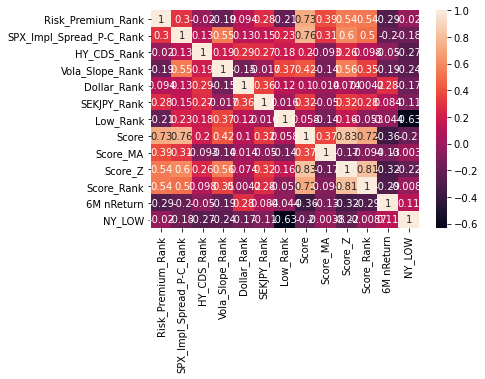

In [68]:
df = do_Strat(dff)
df_new = df[[ 'Risk_Premium_Rank', 'SPX_Impl_Spread_P-C_Rank',
       'HY_CDS_Rank', 'Vola_Slope_Rank', 'Dollar_Rank', 'SEKJPY_Rank', 'Low_Rank', 'Score', 'Score_MA', 'Score_Z',
       'Score_Rank', '6M nReturn', 'NY_LOW']]

corrMatrix = df_new.corr()

sn.heatmap(corrMatrix, annot=True)

plt.show()

In [342]:
import statsmodels.api as sm
df = do_Strat(dff)

slr_model = sm.OLS(df['6M nReturn'], df[[ 'Risk_Premium', 'Vola_Slope', 'Dollar ', 'SB_Ratio', 'HY_CDS', 'Low_Rank', 'SEKJPY']])
slr_reg = slr_model.fit()
print(slr_reg.summary())

# 'SB_Ratio', 'SPX_Impl_Spread_P-C',

                                 OLS Regression Results                                
Dep. Variable:             6M nReturn   R-squared (uncentered):                   0.609
Model:                            OLS   Adj. R-squared (uncentered):              0.608
Method:                 Least Squares   F-statistic:                              395.8
Date:                Wed, 02 Jun 2021   Prob (F-statistic):                        0.00
Time:                        12:53:09   Log-Likelihood:                          2624.3
No. Observations:                1784   AIC:                                     -5235.
Df Residuals:                    1777   BIC:                                     -5196.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

In [37]:
df.columns

Index(['Date', 'Fwd_Earnings', 'Stock_P', 'Stock_Vol', 'US10Y_Yield',
       'Put_Call', 'SPX_P', 'Bond_P', 'Earnings', 'Stock_Volume',
       'SPX_Impl_Spread_P-C', 'Dollar ', 'Vola_Slope', 'HY_CDS', 'SEKJPY',
       'NY_HIGH', 'NY_LOW', '1M nReturn', '3M nReturn', '6M nReturn',
       'Stock_MA', 'Stock_r', 'Bond_r', 'SB_Ratio', 'SB_Ratio_Rank',
       'Risk_Premium', 'Risk_Premium_Rank', 'SPX_Impl_Spread_P-C_Rank',
       'HY_CDS_Rank', 'Vola_Slope_Rank', 'Dollar_Rank', 'SEKJPY_Rank',
       'High_Low', 'High_Low_Rank', 'Score', 'Score_MA', 'Score_Z',
       'Score_Rank'],
      dtype='object')

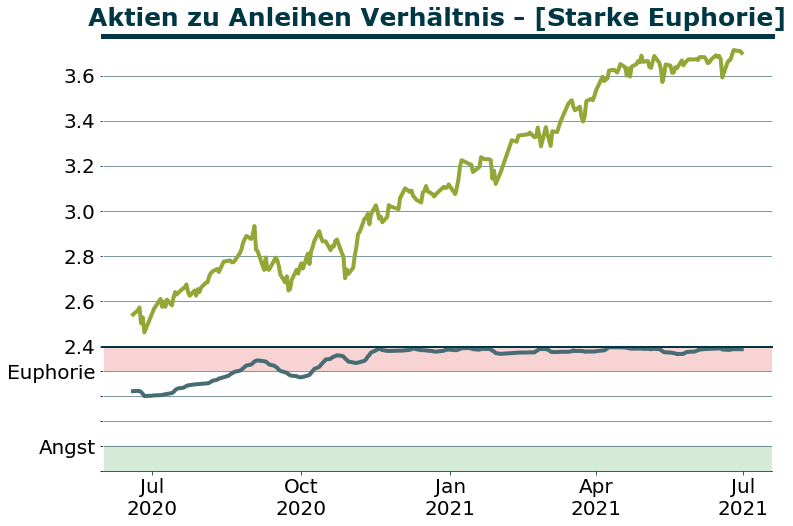

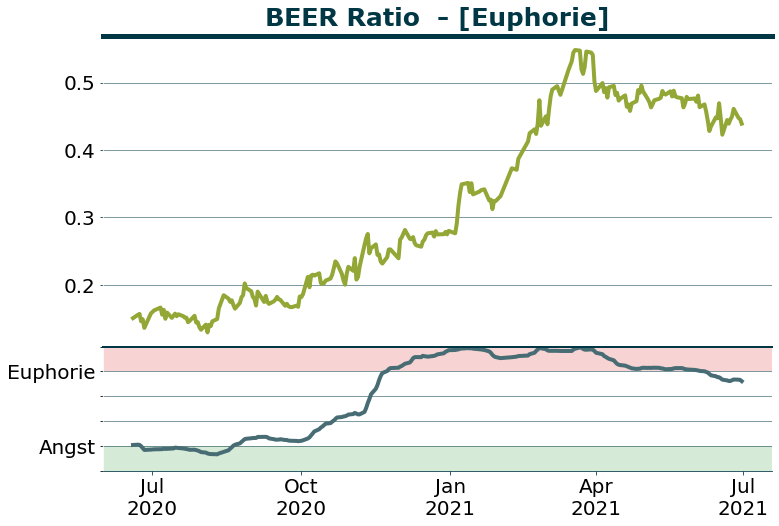

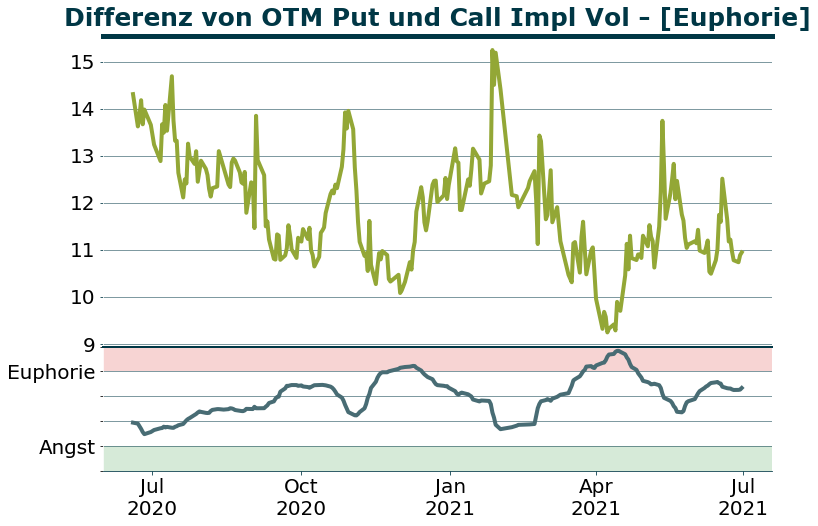

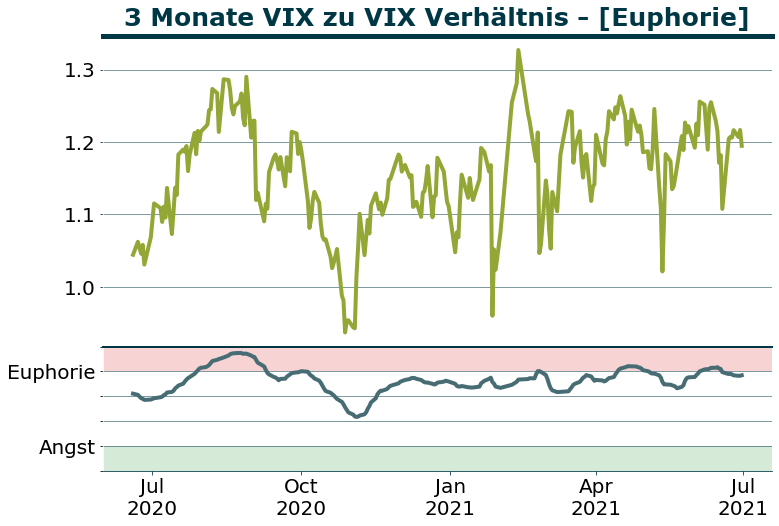

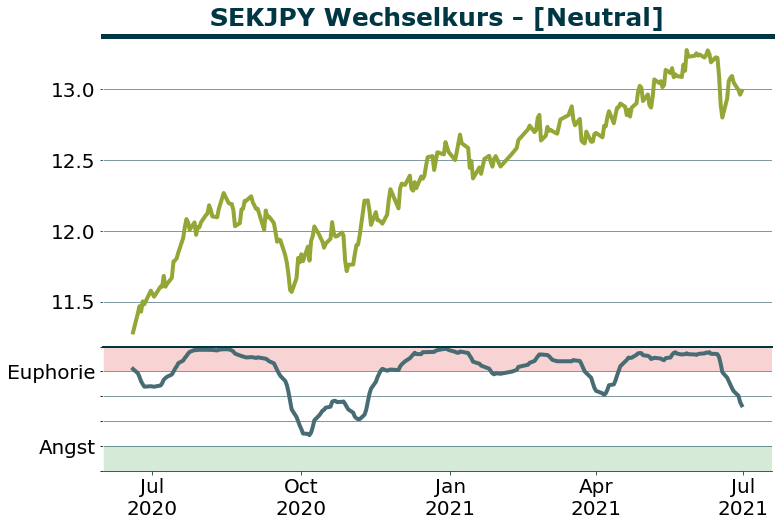

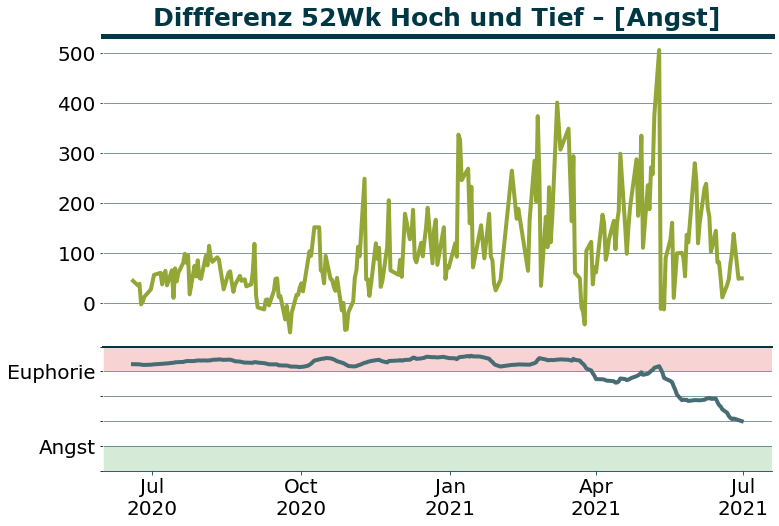

In [39]:
for i in range(6):

    choose = i

    df = do_Strat(dff, evaluate=False)

    options1 = [df['SB_Ratio'], df['Risk_Premium'], df['SPX_Impl_Spread_P-C'], df['Vola_Slope'], df['SEKJPY'], df['High-Low']]
    options2 = ['SB_Ratio_Rank', 'Risk_Premium_Rank', 'SPX_Impl_Spread_P-C_Rank', 'Vola_Slope_Rank', 'SEKJPY_Rank', 'High_Low_Rank' ]
    options3 = ['Aktien zu Anleihen Verhältnis', 'BEER Ratio ','Differenz von OTM Put und Call Impl Vol', '3 Monate VIX zu VIX Verhältnis', 'SEKJPY Wechselkurs', 'Diffferenz 52Wk Hoch und Tief']

    fig = plt.figure(figsize=(12,8), constrained_layout=True)
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 2]) 
    fig.patch.set_facecolor('w')

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex=ax0)

    majorLocator = MultipleLocator(20)

    ax0.plot(df['Date'][-240:], options1[choose][-240:], linewidth = 4, color ='#93a736')
    ax0.set_title(f"{options3[choose]} - [{sentiment[int(df[options2[choose]].iloc[-1]*5)/5]}]", fontsize=25, color='#003745', fontweight='bold', fontname="Verdana", pad=10)
    ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax0.grid(linewidth = 0.5, axis='y', color = '#003745', linestyle = '-')
    ax0.get_xaxis().set_visible(False)
    ax0.spines['bottom'].set_color('w')
    ax0.spines['top'].set_color('#003745')
    ax0.spines['top'].set_linewidth(5)
    ax0.spines['left'].set_color('w')
    ax0.spines['right'].set_color('w')
    ax0.tick_params(axis='y', labelsize=20, color='#003745')




    ax1.plot(df['Date'][-240:], df[options2[choose]][-240:]*100, linewidth = 4, color ='#486c74')
    ax1.spines['bottom'].set_color('#003745')
    ax1.spines['top'].set_color('#003745')
    ax1.spines['top'].set_linewidth(2)
    ax1.spines['left'].set_color('w')
    ax1.spines['right'].set_color('w')

    ax1.grid(linewidth = 0.5, axis='y', color = '#003745', linestyle = '-')

    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax1.tick_params(axis='x', labelsize=20, color='#003745')
    ax1.axhspan(100*buy, 100*(buy-buy), facecolor='#7ABC81', alpha=0.3)
    ax1.axhspan(100*sell, 100*(sell+buy), facecolor='#E77270', alpha=0.3)

    ax1.set_ylim((0,100))
    ax1.yaxis.set_major_locator(majorLocator)
    ax1.set_yticklabels(['','','Angst','', '', 'Euphorie'], ha="right", fontname="Verdana",)
    ax1.tick_params(axis='y', labelsize=20)


    plt.subplots_adjust(hspace=.0)

    plt.savefig(options3[choose], dpi=500, facecolor = 'w')

    plt.show()

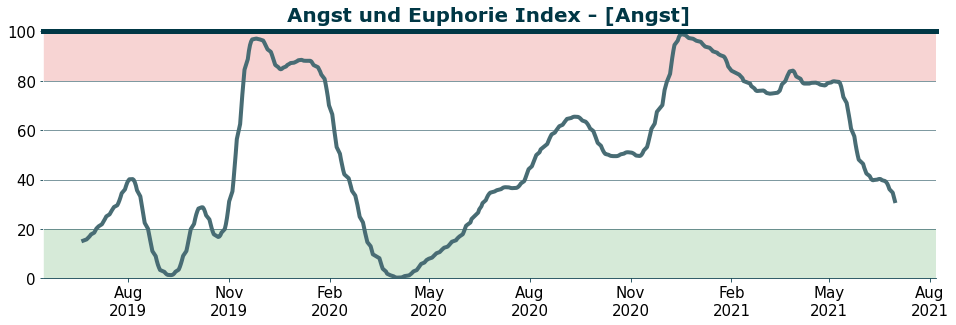

In [30]:
buy = 0.2
sell = 0.8

sentiment = {0.0:'Starke Angst', 0.2:'Angst', 0.4:'Neutral', 0.6:'Euphorie', 0.8:'Starke Euphorie'}

%matplotlib inline 

df = do_Strat(dff, evaluate=False)

fig = plt.figure(figsize=(16,8), constrained_layout=True)
fig.patch.set_facecolor('w')

ax0 = plt.subplot(gs[0])

majorLocator = MultipleLocator(20)

ax0.plot(df['Date'][-480:], 100*df['Score_Rank'][-480:], linewidth = 4, color ='#486c74')
ax0.set_title(f"Angst und Euphorie Index - [{sentiment[int(df['Score_Rank'].iloc[-1]*5)/5]}]", fontsize=20, color='#003745', fontweight='bold', fontname="Verdana", pad=10)

ax0.spines['bottom'].set_color('#003745')
ax0.spines['top'].set_color('#003745')
ax0.spines['top'].set_linewidth(5)
ax0.spines['left'].set_color('w')
ax0.spines['right'].set_color('w')

ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

ax0.tick_params(axis='x', labelsize=15, color='#003745')
ax0.grid(linewidth = 0.5, axis='y', color = '#003745', linestyle = '-')
ax0.tick_params(axis='y', labelsize=15, color='#003745')
ax0.axhspan(100*buy, 100*(buy-buy), facecolor='#7ABC81', alpha=0.3)
ax0.axhspan(100*sell, 100*(sell+buy), facecolor='#E77270', alpha=0.3)
ax0.set_ylim((0,100))
ax0.yaxis.set_major_locator(majorLocator)

plt.savefig('G Index', dpi=500, facecolor = 'w')

plt.show()

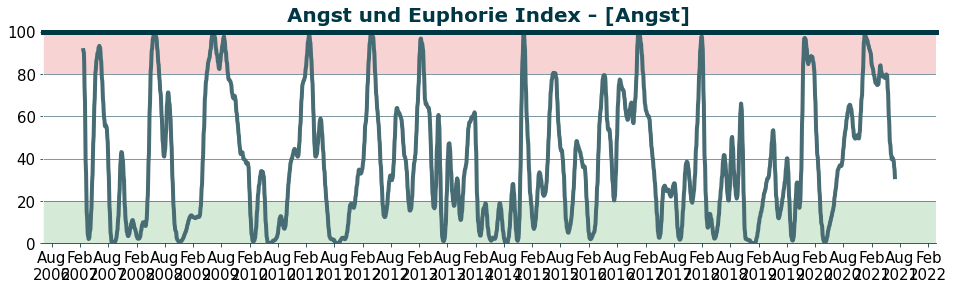

In [41]:
buy = 0.2
sell = 0.8

sentiment = {0.0:'Starke Angst', 0.2:'Angst', 0.4:'Neutral', 0.6:'Euphorie', 0.8:'Starke Euphorie'}

%matplotlib inline 

df = do_Strat(dff, evaluate=False)

fig = plt.figure(figsize=(16,6), constrained_layout=True)
fig.patch.set_facecolor('w')

ax0 = plt.subplot(gs[0])

majorLocator = MultipleLocator(20)

ax0.plot(df['Date'], 100*df['Score_Rank'], linewidth = 4, color ='#486c74')
ax0.set_title(f"Angst und Euphorie Index - [{sentiment[int(df['Score_Rank'].iloc[-1]*5)/5]}]", fontsize=20, color='#003745', fontweight='bold', fontname="Verdana", pad=10)

ax0.spines['bottom'].set_color('#003745')
ax0.spines['top'].set_color('#003745')
ax0.spines['top'].set_linewidth(5)
ax0.spines['left'].set_color('w')
ax0.spines['right'].set_color('w')

ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

ax0.tick_params(axis='x', labelsize=15, color='#003745')
ax0.grid(linewidth = 0.5, axis='y', color = '#003745', linestyle = '-')
ax0.tick_params(axis='y', labelsize=15, color='#003745')
ax0.axhspan(100*buy, 100*(buy-buy), facecolor='#7ABC81', alpha=0.3)
ax0.axhspan(100*sell, 100, facecolor='#E77270', alpha=0.3)
ax0.set_ylim((0,100))
ax0.yaxis.set_major_locator(majorLocator)

plt.savefig('G Index Long', dpi=500, facecolor = 'w')

plt.show()

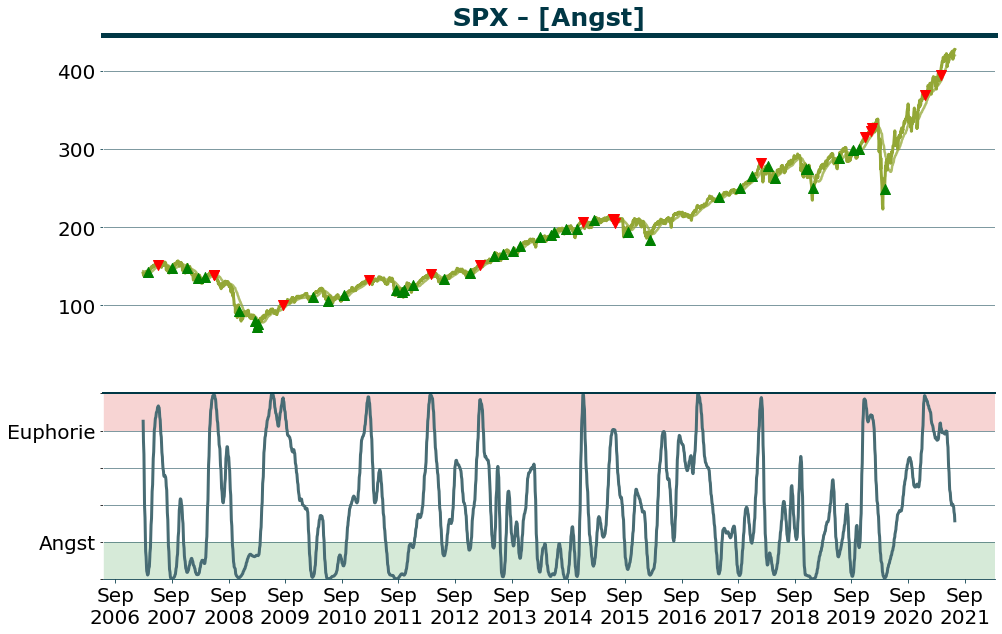

In [31]:
df = do_Strat(dff, evaluate=False)

buy=0.2
sell=0.8

df['SELL'] = (df['Score_Rank']> sell) & (df['Score_Rank'].shift(1) > df['Score_Rank']) & (df['Score_Rank'].shift(2) < df['Score_Rank'].shift(1))
df['BUY'] = (df['Score_Rank'] < buy) & (df['Score_Rank'].shift(1) < df['Score_Rank']) & (df['Score_Rank'].shift(2) > df['Score_Rank'].shift(1)) 

fig = plt.figure(figsize=(16,10), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, height_ratios=[5, 3]) 
fig.patch.set_facecolor('w')

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

majorLocator = MultipleLocator(20)

ax0.plot(df['Date'][540:], df['Stock_P'][540:], linewidth = 3, color ='#93a736')
ax0.plot(df['Date'][540:], df['Stock_MA'][540:], linewidth = 2.5, color ='#93a736', alpha =0.75)
ax0.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], 'Stock_P'].values, label='skitscat', color='red', s=100, marker="v", zorder=10)
ax0.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], 'Stock_P'].values, label='skitscat', color='green', s=100, marker="^", zorder=10)
ax0.set_title(f"SPX - [{sentiment[int(df['Score_Rank'].iloc[-1]*5)/5]}]", fontsize=25, color='#003745', fontweight='bold', fontname="Verdana", pad=10)
ax0.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax0.grid(linewidth = 0.5, axis='y', color = '#003745', linestyle = '-')
ax0.get_xaxis().set_visible(False)
ax0.spines['bottom'].set_color('w')
ax0.spines['top'].set_color('#003745')
ax0.spines['top'].set_linewidth(5)
ax0.spines['left'].set_color('w')
ax0.spines['right'].set_color('w')
ax0.tick_params(axis='y', labelsize=20, color='#003745')

ax1.plot(df['Date'][540:], df['Score_Rank'][540:]*100, linewidth = 3, color ='#486c74')
ax1.spines['bottom'].set_color('#003745')
ax1.spines['top'].set_color('#003745')
ax1.spines['top'].set_linewidth(2)
ax1.spines['left'].set_color('w')
ax1.spines['right'].set_color('w')

ax1.grid(linewidth = 0.5, axis='y', color = '#003745', linestyle = '-')

ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax1.tick_params(axis='x', labelsize=20, color='#003745')
ax1.axhspan(100*buy, 100*(buy-buy), facecolor='#7ABC81', alpha=0.3)
ax1.axhspan(100*sell, 100*(sell+buy), facecolor='#E77270', alpha=0.3)

ax1.set_ylim((0,100))
ax1.yaxis.set_major_locator(majorLocator)
ax1.set_yticklabels(['','','Angst','', '', 'Euphorie'], ha="right", fontname="Verdana",)
ax1.tick_params(axis='y', labelsize=20)

plt.savefig('G Index Long', dpi=500, facecolor = 'w')

plt.show()

In [46]:
df[500:560]

,Date,SPX_P,Earnings,VIX_CALL,VIX_PUT,SPX_Impl_Spread_P-C,Stock_P,VIX,VIX3M,Vola_Slope,...,High_Low_Rank_0,High_Low_Rank_1,High_Low_Rank_2,High_Low_Rank,Score,Score_MA,Score_Z,Score_Rank,SELL,BUY
1823,2006-12-28,1424.73,83.59,7.73,10.14,8.1432,142.21,10.99,13.15,1.196542,...,0.561644,0.566396,0.561644,0.586568,4.101589,NaN,NaN,NaN,False,False
1824,2006-12-29,1418.30,83.63,8.26,10.72,8.5027,141.62,11.56,13.46,1.164360,...,0.502740,0.508130,0.502740,0.558860,4.042051,NaN,NaN,NaN,False,False
1827,2007-01-03,1416.60,85.62,8.70,11.13,8.0660,141.37,12.04,13.59,1.128738,...,0.598630,0.602981,0.598630,0.548487,4.005334,NaN,NaN,NaN,False,False
1828,2007-01-04,1418.34,85.61,8.10,10.41,7.9903,141.67,11.51,13.21,1.147698,...,0.453425,0.459350,0.453425,0.534838,3.940894,NaN,NaN,NaN,False,False
1829,2007-01-05,1409.71,85.61,9.36,11.44,8.0242,140.54,12.14,13.64,1.123558,...,0.380822,0.387534,0.380822,0.524601,3.855810,NaN,NaN,NaN,False,False
1830,2007-01-08,1412.84,85.61,9.03,11.42,8.2370,141.19,12.00,13.43,1.119167,...,0.373973,0.380759,0.373973,0.501261,3.753157,NaN,NaN,NaN,False,False
1831,2007-01-09,1412.11,85.61,9.09,11.49,8.2599,141.07,11.91,13.40,1.125105,...,0.464384,0.464384,0.464384,0.494789,3.685094,NaN,NaN,NaN,False,False
1832,2007-01-10,1414.85,85.57,8.16,10.40,8.3148,141.54,11.47,13.03,1.136007,...,0.454795,0.454795,0.454795,0.496502,3.648311,NaN,NaN,NaN,False,False
1833,2007-01-11,1423.83,85.56,7.96,10.10,7.9372,142.16,10.87,12.59,1.158234,...,0.623288,0.623288,0.623288,0.508514,3.655804,NaN,NaN,NaN,False,False
1834,2007-01-12,1430.73,85.56,6.70,9.25,8.2401,143.24,10.15,12.11,1.193103,...,0.610959,0.610959,0.610959,0.503596,3.650160,NaN,NaN,NaN,False,False


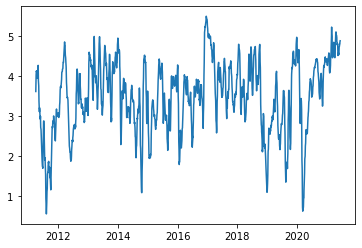

In [232]:
plt.plot(df['Date'], df['Score'])

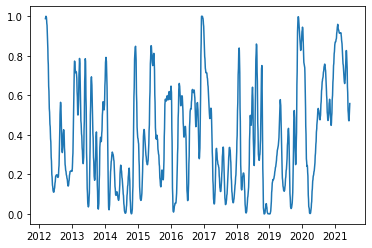

In [233]:
plt.plot(df['Date'], df['Score_Rank'])

In [246]:
df[(df['US10Y_Yield']==df['US10Y_Yield'][-300:].min())]

,Date,SPX_P,Earnings,VIX_CALL,VIX_PUT,SPX_Impl_Spread_P-C,Stock_P,VIX,VVIX_CALL,VVIX_PUT,...,SEKJPY_Rank,High_Low,Low_Rank,High_Rank,High-Low,High_Low_Rank,Score,Score_MA,Score_Z,Score_Rank
2762,2020-08-04,3306.51,130.76,15.64,21.98,6.34,326.28,23.76,145.6,93.36,...,0.97018,20.0,0.804382,0.337607,76.0,0.886756,4.210001,3.356214,0.80649,0.642337


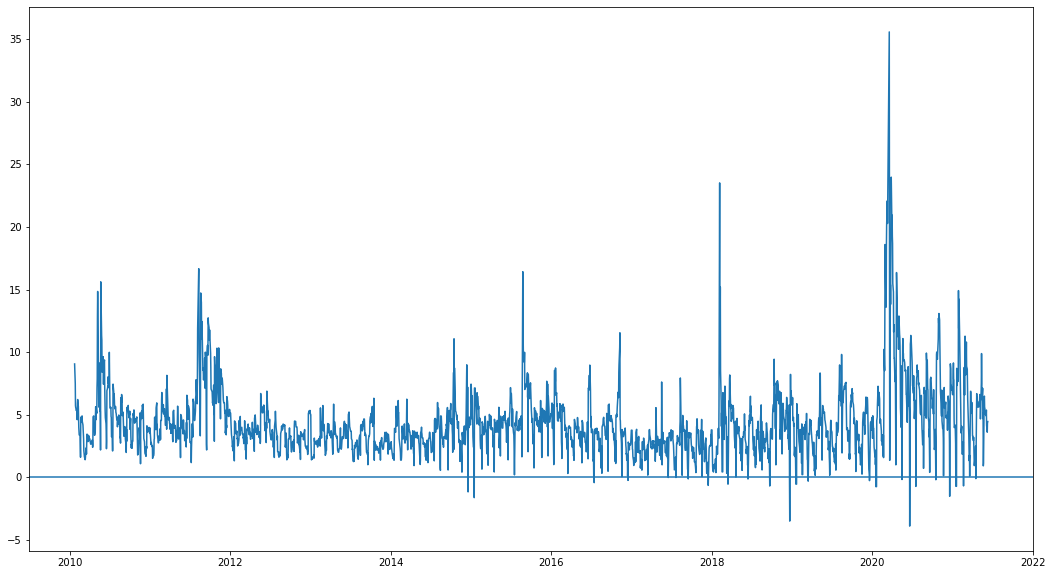

In [261]:
plt.subplots(figsize=(18,10))
plt.plot(df['Date'], df['SPX_Impl_Spread_P-C'])
plt.axhline(y=0)
plt.show()

In [386]:
df['SELL'].tail(60)

2915    False
2916    False
2918    False
2921    False
2923    False
2924    False
2925    False
2926    False
2927    False
2928    False
2929    False
2930    False
2931     True
2932    False
2933    False
2934    False
2936    False
2937    False
2938    False
2939    False
2940    False
2941    False
2942    False
2943    False
2944    False
2945    False
2946    False
2947    False
2948    False
2949    False
2950    False
2951    False
2952    False
2953    False
2954    False
2955    False
2956    False
2957    False
2958    False
2959    False
2960     True
2961    False
2962    False
2963    False
2964    False
2965    False
2966    False
2967    False
2968    False
2969    False
2970    False
2971    False
2972    False
2973    False
2974    False
2975    False
2977    False
2978    False
2979    False
2980    False
Name: SELL, dtype: bool

In [390]:
df.tail(60)

,Date,SPX_P,Earnings,VIX_CALL,VIX_PUT,SPX_Impl_Spread_P-C,Stock_P,VIX,VVIX_CALL,VVIX_PUT,...,Low_Rank,High_Rank,High-Low,High_Low_Rank,Score,Score_MA,Score_Z,Score_Rank,SELL,BUY
2915,2021-03-05,3841.94,123.99,16.78,25.65,9.0923,382.378,24.66,181.84,105.97,...,0.600209,0.508021,174.0,0.890533,4.782340,3.631260,1.122534,0.813131,False,False
2916,2021-03-08,3821.35,123.99,18.90,27.55,9.3376,380.474,25.47,193.35,110.39,...,0.844976,1.000000,401.0,0.893952,4.740894,3.637592,1.073692,0.814853,False,False
2918,2021-03-10,3898.81,123.94,15.69,21.92,7.5415,388.308,22.56,146.52,80.70,...,0.902191,0.764268,307.0,0.896765,4.751863,3.643276,1.076340,0.821062,False,False
2921,2021-03-15,3968.94,123.94,14.51,17.87,5.4637,395.116,20.03,133.01,100.82,...,1.000000,0.866005,349.0,0.893484,4.776680,3.648633,1.092535,0.830305,False,False
2923,2021-03-17,3974.12,123.94,14.74,16.07,5.4035,395.963,19.23,140.74,80.18,...,0.902191,0.409429,164.0,0.886234,4.880177,3.654254,1.183860,0.843556,False,False
2924,2021-03-18,3915.46,123.94,21.36,23.14,7.0485,390.202,21.58,149.95,89.00,...,0.902191,0.732010,294.0,0.901242,4.985753,3.660334,1.275600,0.860965,False,False
2925,2021-03-19,3913.10,123.94,10.70,10.80,6.4355,389.480,20.95,149.66,86.48,...,0.902191,0.153846,61.0,0.892692,5.008715,3.666670,1.287172,0.875610,False,False
2926,2021-03-22,3940.59,123.09,12.44,18.07,5.8850,392.590,18.88,145.73,79.06,...,0.706573,0.141439,50.0,0.887363,5.052341,3.673817,1.317605,0.888810,False,False
2927,2021-03-23,3910.52,123.09,13.05,19.92,7.1999,389.500,20.30,149.34,88.11,...,0.502400,0.062035,-8.0,0.870673,5.008343,3.681698,1.264505,0.898328,False,False
2928,2021-03-24,3889.14,123.09,13.64,20.52,7.0266,387.520,21.20,145.18,88.17,...,0.462847,0.066998,-17.0,0.860475,4.982627,3.690479,1.229235,0.905645,False,False


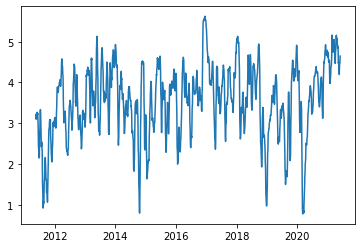

In [400]:
plt.plot(df['Date'], df['Score'])

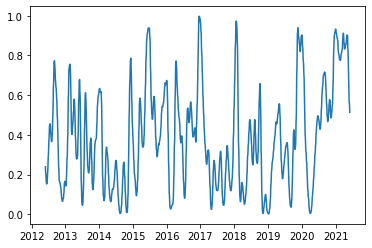

In [401]:
plt.plot(df['Date'], df['Score_Rank'])

,Date,SPX_P,Earnings,VIX_CALL,VIX_PUT,SPX_Impl_Spread_P-C,Stock_P,VIX,VIX3M,Vola_Slope,Bond_P,US10Y_Yield,NY_HIGH,NY_LOW,SEKJPY
2612,2010-01-06,1137.14,57.88,13.48,15.84,4.0394,113.71,19.16,21.80,1.137787,88.85,3.8215,306.0,1.0,13.0534
2613,2010-01-07,1141.70,57.88,13.83,16.35,4.0658,114.19,19.06,21.60,1.133263,88.85,3.8235,217.0,2.0,13.0933
2614,2010-01-08,1144.98,57.88,12.53,14.89,3.3210,114.57,18.13,21.00,1.158301,88.96,3.8297,262.0,1.0,13.0953
2615,2010-01-11,1146.98,57.88,13.48,16.12,3.8932,114.73,17.55,21.27,1.211966,89.02,3.8180,364.0,1.0,13.1068
2616,2010-01-12,1136.22,57.88,14.07,17.02,3.2686,113.66,18.25,21.79,1.193973,89.66,3.7108,98.0,2.0,12.8919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5584,2021-05-28,4204.11,140.90,10.28,15.34,5.4260,420.04,16.76,20.48,1.221957,114.40,1.5943,130.0,8.0,13.2270
5586,2021-06-01,4202.04,141.64,11.53,16.67,6.1688,419.67,17.90,21.34,1.192179,114.30,1.6062,287.0,7.0,13.2340
5587,2021-06-02,4208.12,141.64,10.81,15.73,5.9048,420.33,17.48,21.42,1.225400,114.43,1.5875,245.0,2.0,13.2515
5588,2021-06-03,4192.85,141.68,11.23,16.61,6.3998,418.77,18.04,21.82,1.209534,114.14,1.6250,126.0,6.0,13.2351


Int64Index([2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236,
            2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247,
            2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258,
            2259, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269,
            2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280,
            2281, 2282, 2283, 2284, 2285, 2286, 2291, 2292, 2293, 2294, 2295,
            2296, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309,
            2311, 2329, 2346, 2347, 2348, 2349, 2350, 2574, 2575, 2576, 2577,
            2578, 2579, 2580, 2581, 2582, 2585, 2586, 2587, 2588, 2589, 2591,
            2598],
           dtype='int64')

[]

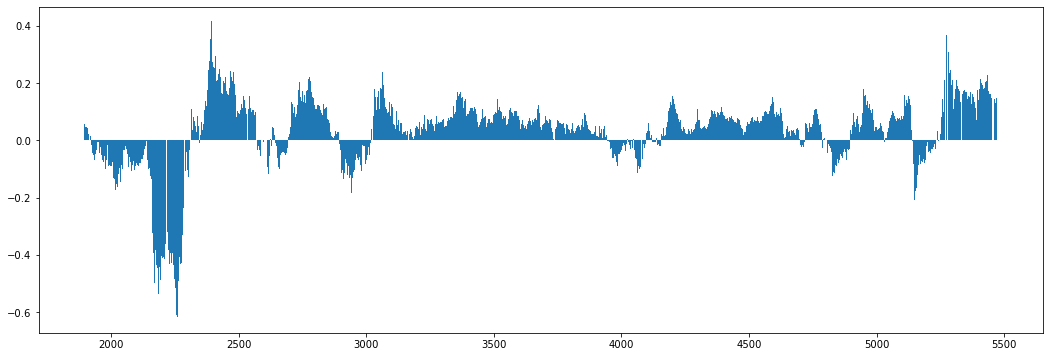

In [49]:
plt.figure(figsize=(18,6))
plt.bar(df.index, df['6M nReturn'], width=1, zorder=0)
plt.plot()

In [75]:
df[(df.index == 2591)]

,Date,SPX_P,Earnings,VIX_CALL,VIX_PUT,SPX_Impl_Spread_P-C,Stock_P,VIX,VIX3M,Vola_Slope,...,High_Low_Rank_0,High_Low_Rank_1,High_Low_Rank_2,High_Low_Rank,Score,Score_MA,Score_Z,Score_Rank,SELL,BUY
2591,2009-12-08,1091.94,45.42,17.51,21.82,4.31,109.61,23.69,26.13,1.102997,...,0.755311,0.811619,0.686385,0.811056,4.34699,3.728991,0.657899,0.890063,False,False


In [87]:
df[df['6M nReturn']<=0].index[0:500]

Int64Index([1913, 1914, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929,
            ...
            2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926],
           dtype='int64', length=500)

In [99]:
qqq =3300
df[qqq:qqq+100]

,Date,SPX_P,Earnings,VIX_CALL,VIX_PUT,SPX_Impl_Spread_P-C,Stock_P,VIX,VIX3M,Vola_Slope,...,High_Low_Rank_0,High_Low_Rank_1,High_Low_Rank_2,High_Low_Rank,Score,Score_MA,Score_Z,Score_Rank,SELL,BUY
5245,2020-02-10,3352.09,151.88,9.47,13.44,3.97,334.68,15.04,16.13,1.072473,...,0.572314,0.806361,0.572314,0.691040,3.301399,3.355631,-0.063465,0.428518,False,False
5246,2020-02-11,3357.75,151.88,9.81,13.53,3.72,335.26,15.18,16.14,1.063241,...,0.834711,0.925164,0.834711,0.710635,3.363059,3.355642,0.008679,0.390664,False,False
5247,2020-02-12,3379.45,151.88,8.32,11.22,2.90,337.42,13.74,15.36,1.117904,...,0.838843,0.927035,0.838843,0.726852,3.484924,3.356719,0.150028,0.357579,False,False
5248,2020-02-13,3373.94,151.87,8.62,12.03,3.41,337.06,14.15,15.68,1.108127,...,0.795455,0.907390,0.795455,0.749994,3.569086,3.358501,0.246428,0.329972,False,False
5249,2020-02-14,3380.16,151.87,7.84,10.41,2.57,337.60,13.68,15.50,1.133041,...,0.797521,0.908326,0.797521,0.779894,3.747745,3.361396,0.452009,0.310452,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5353,2020-07-09,3152.05,129.38,19.27,26.41,7.14,314.38,29.26,32.06,1.095694,...,0.884561,0.884561,0.884561,0.865227,3.687383,3.303177,0.397489,0.373725,False,False
5354,2020-07-10,3185.04,129.39,17.43,22.13,4.70,317.59,27.29,31.02,1.136680,...,0.864023,0.864023,0.864023,0.867918,3.835327,3.309492,0.544745,0.371590,False,False
5355,2020-07-13,3155.22,129.39,25.61,31.40,5.79,314.84,32.19,34.54,1.073004,...,0.885269,0.885269,0.885269,0.872380,3.894444,3.316836,0.599631,0.371743,False,False
5356,2020-07-14,3197.52,129.40,23.98,29.90,5.92,318.92,29.52,32.56,1.102981,...,0.846317,0.846317,0.846317,0.872238,4.021947,3.325185,0.725029,0.375796,False,False


In [25]:
df[-100:-40]

,Date,SPX_P,Earnings,VIX_CALL,VIX_PUT,SPX_Impl_Spread_P-C,Stock_P,VIX,VIX3M,Vola_Slope,...,High_Low_Rank_0,High_Low_Rank_1,High_Low_Rank_2,High_Low_Rank,Score,Score_MA,Score_Z,Score_Rank,SELL,BUY
5361,2020-07-21,3257.30,129.40,17.41,25.43,12.4947,325.01,24.84,29.47,1.186393,...,0.908640,0.908640,0.908640,0.880312,3.753462,3.331432,0.369007,0.368654,False,False
5362,2020-07-22,3276.02,129.40,16.47,24.52,12.4082,326.86,24.32,29.05,1.194490,...,0.895892,0.895892,0.895892,0.882011,3.802695,3.334185,0.409479,0.372499,False,False
5363,2020-07-23,3235.66,129.40,17.41,26.39,13.2542,322.96,26.08,30.25,1.159893,...,0.906516,0.906516,0.906516,0.884207,3.851105,3.336401,0.449627,0.377742,False,False
5364,2020-07-24,3215.63,129.40,17.48,25.83,12.9796,320.88,25.84,30.56,1.182663,...,0.851275,0.851275,0.851275,0.882932,3.877397,3.338261,0.470732,0.384403,False,False
5365,2020-07-27,3239.41,129.48,16.40,24.72,12.8244,323.22,24.74,30.00,1.212611,...,0.891643,0.891643,0.891643,0.883569,3.949867,3.340352,0.531840,0.393512,False,False
5366,2020-07-28,3218.44,129.48,16.85,25.37,13.0933,321.17,25.44,30.10,1.183176,...,0.876771,0.876771,0.876771,0.886615,3.972910,3.342478,0.549717,0.404369,False,False
5367,2020-07-29,3258.44,129.49,16.09,23.51,12.4444,325.12,24.10,29.29,1.215353,...,0.899433,0.899433,0.899433,0.887748,3.999401,3.344962,0.570209,0.416975,False,False
5368,2020-07-30,3246.22,129.49,16.64,24.20,12.6665,323.96,24.76,29.76,1.201939,...,0.874646,0.874646,0.874646,0.888244,4.018883,3.347801,0.584218,0.429617,False,False
5369,2020-07-31,3271.12,129.75,15.98,23.32,12.8914,326.52,24.46,29.71,1.214636,...,0.873229,0.873229,0.873229,0.887394,4.015125,3.351052,0.577630,0.441903,False,False
5370,2020-08-03,3294.61,129.73,15.98,22.95,12.7177,328.79,24.28,29.66,1.221582,...,0.905807,0.905807,0.905807,0.888385,4.012252,3.355000,0.571244,0.453701,False,False


In [35]:
df['Score_Rank']

1305         NaN
1306         NaN
1307         NaN
1308         NaN
1309         NaN
          ...   
5603    0.373689
5604    0.361056
5605    0.346916
5606    0.330642
5607    0.312907
Name: Score_Rank, Length: 4077, dtype: float64

In [38]:
df = do_Strat(dff, evaluate=False)

In [44]:
df.columns

Index(['Date', 'SPX_P', 'Earnings', 'VIX_CALL', 'VIX_PUT',
       'SPX_Impl_Spread_P-C', 'Stock_P', 'VIX', 'VIX3M', 'Vola_Slope',
       'Bond_P', 'US10Y_Yield', 'NY_HIGH', 'NY_LOW', 'SEKJPY', '1M nReturn',
       '3M nReturn', '6M nReturn', 'Stock_MA', 'Stock_r', 'Bond_r', 'SB_Dif',
       'SB_Ratio', 'SB_Ratio_Rank', 'Risk_Premium', 'Risk_Premium_Rank',
       'SPX_Impl_Spread_P-C_Rank', 'Vola_Slope_Rank', 'SEKJPY_Rank',
       'High_Low', 'Low_Rank', 'High_Rank', 'High-Low', 'High_Low_Rank_0',
       'High_Low_Rank_1', 'High_Low_Rank_2', 'High_Low_Rank', 'Score',
       'Score_MA', 'Score_Z', 'Score_Rank'],
      dtype='object')

In [91]:
df = do_Strat(dff, evaluate=False)
df[['Date', 'SB_Ratio_Rank', 'Risk_Premium_Rank', 'SPX_Impl_Spread_P-C_Rank', 'Vola_Slope_Rank', 'SEKJPY_Rank', 'High_Low_Rank','High_Low_Rank_0' , 'High_Low_Rank_1','High_Low_Rank_2' , 'Score', 'High-Low', 'Score_Rank']].tail(60)

,Date,SB_Ratio_Rank,Risk_Premium_Rank,SPX_Impl_Spread_P-C_Rank,Vola_Slope_Rank,SEKJPY_Rank,High_Low_Rank,High_Low_Rank_0,High_Low_Rank_1,High_Low_Rank_2,Score,High-Low,Score_Rank
5547,2021-04-07,0.976275,0.916883,0.889507,0.724483,0.623948,0.728378,0.441281,0.801893,0.801893,4.859475,87.0,0.791531
5548,2021-04-08,0.986274,0.908488,0.918841,0.735431,0.651656,0.724440,0.467972,0.811356,0.811356,4.925131,102.0,0.788700
5549,2021-04-09,0.994451,0.901223,0.935666,0.746233,0.688805,0.724715,0.514235,0.827760,0.827760,4.991093,128.0,0.788421
5550,2021-04-12,0.994936,0.889061,0.940527,0.754430,0.695309,0.720942,0.515400,0.851104,0.851104,4.995205,165.0,0.788139
5551,2021-04-13,0.994502,0.874014,0.957320,0.776639,0.726444,0.709514,0.398357,0.815142,0.815142,5.038434,108.0,0.788478
5552,2021-04-14,0.993981,0.860563,0.965287,0.794119,0.767510,0.710458,0.509240,0.849211,0.849211,5.091918,162.0,0.790234
5553,2021-04-15,0.993981,0.853665,0.965529,0.813185,0.804723,0.719830,0.554415,0.863091,0.863091,5.150914,184.0,0.791438
5554,2021-04-16,0.993981,0.850949,0.957881,0.822338,0.841472,0.742924,0.790554,0.935647,0.935647,5.209544,299.0,0.791683
5555,2021-04-19,0.992575,0.846605,0.937699,0.833608,0.880159,0.738336,0.492813,0.844164,0.844164,5.228982,154.0,0.792232
5556,2021-04-20,0.989510,0.841442,0.912425,0.838532,0.891779,0.729394,0.379877,0.809464,0.809464,5.203082,99.0,0.790416


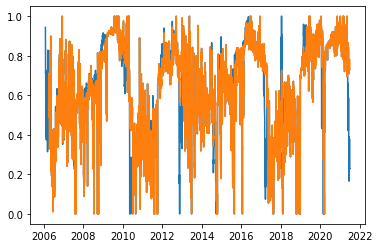

In [82]:
plt.plot(df['Date'], df['High_Low_Rank_0'])
plt.plot(df['Date'], df['High_Low_Rank_1'])
plt.show()

In [96]:
dff.head(60)

,Date,SPX_P,Earnings,VIX_CALL,VIX_PUT,SPX_Impl_Spread_P-C,Stock_P,VIX,VIX3M,Vola_Slope,Bond_P,US10Y_Yield,NY_HIGH,NY_LOW,SEKJPY
1305,2005-01-03,1202.08,65.24,11.64,13.68,1.9889,120.30,14.08,15.07,1.070312,85.12,4.2104,168.0,7.0,15.3166
1306,2005-01-04,1188.05,65.24,11.74,13.48,2.1341,118.83,13.98,15.05,1.076538,84.59,4.2886,35.0,9.0,15.3377
1307,2005-01-05,1183.74,65.24,11.80,13.65,2.1046,118.01,14.09,15.21,1.079489,84.73,4.2808,23.0,15.0,15.3018
1308,2005-01-06,1187.89,65.20,11.65,12.94,1.9589,118.61,13.58,14.59,1.074374,84.81,4.2612,31.0,16.0,15.2687
1309,2005-01-07,1186.19,65.20,11.33,12.50,2.0653,118.44,13.49,14.52,1.076353,84.74,4.2690,43.0,16.0,15.1229
1310,2005-01-10,1190.24,65.19,11.28,12.83,2.2703,119.00,13.23,14.31,1.081633,84.73,4.2690,53.0,13.0,15.0854
1311,2005-01-11,1182.99,65.19,11.50,13.13,2.1041,118.18,13.19,14.34,1.087187,84.90,4.2357,41.0,15.0,14.9895
1312,2005-01-12,1187.70,65.19,10.91,12.18,2.2157,118.57,12.56,13.94,1.109873,85.03,4.2337,51.0,15.0,15.0023
1313,2005-01-13,1177.45,65.19,11.44,12.21,1.9184,117.62,12.84,14.22,1.107477,85.37,4.1635,79.0,16.0,14.9554
1314,2005-01-14,1184.52,65.19,10.58,11.69,2.0930,118.24,12.43,13.93,1.120676,85.32,4.2080,95.0,18.0,14.7698
